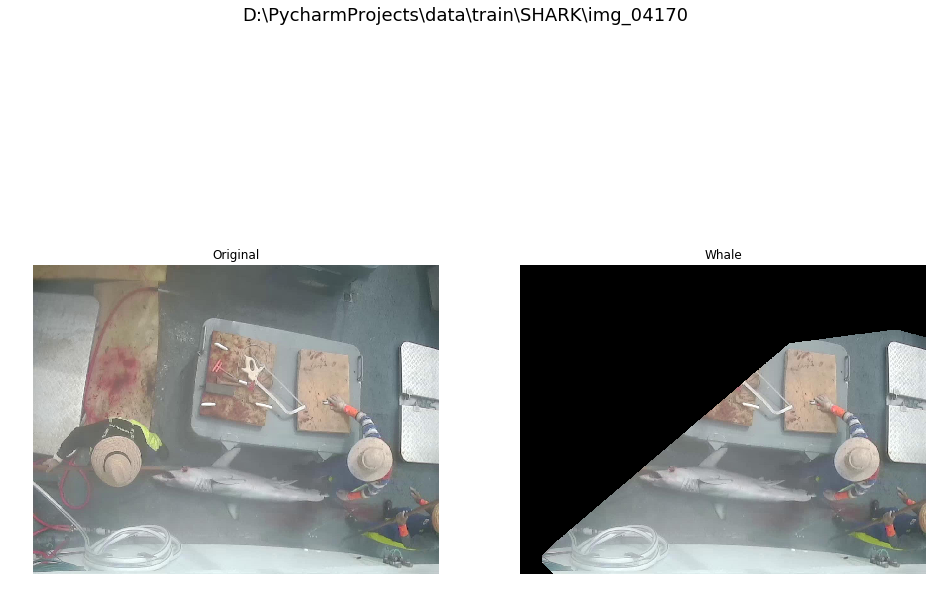

In [ ]:
############################################################
# Python 3.5
# (C) DietCoke
# November 23, 2015
# License: MIT
############################################################

import os
import sys
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_opening, label
from scipy.spatial import ConvexHull
from skimage.filters import threshold_yen
from PIL import Image, ImageDraw

############################################################
# i/o

def subplot_images(images, titles=None, suptitle=False):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(16, 12),
        sharex=True,
        sharey=True,
        subplot_kw={'adjustable':'box-forced'}
    )
    fig.suptitle(suptitle, fontsize=18)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()
    plt.close()


def load_image(filename):
    with open(filename, 'rb') as f:
            return np.asarray(Image.open(f))


############################################################
# geometry

def mask_polygon(verts, shape):
    img = Image.new('L', shape, 0)
    ImageDraw.Draw(img).polygon(verts, outline=1, fill=1)
    mask = np.array(img)

    return mask.T


def convex_hull_mask(data, mask=True):
    segm = np.argwhere(data)
    hull = ConvexHull(segm)
    verts = [(segm[v,0], segm[v,1]) for v in hull.vertices]
    return mask_polygon(verts, data.shape)


def extract_largest_regions(mask, num_regions=2):
    rtn = np.copy(mask)
    regions, n_labels = label(mask)
    label_list = range(1, n_labels+1)
    sizes = []
    for l in label_list:
        size = (regions==l).sum()
        sizes.append((size, l))

    sizes = sorted(sizes, reverse=True)
    num_regions = min(num_regions, n_labels-1)
    min_size = sizes[num_regions][0]

    labels = []
    for s, l in sizes:
        if s < min_size:
            regions[regions==l] = 0
        else:
            labels.append(l)

    return regions, labels


def build_binary_opening_structure(binary_image, weight=1):
    s = 1 + 10000 * (binary_image.sum()/binary_image.size) ** 1.4
    s = int(max(5, 3 * np.log(s) * weight))
    return np.ones((s, s))


############################################################
# main

def simple_whale_detector(filename, dilation_iterations=40, num_regions=2):
    image = load_image(filename)
    image_array = []
    titles = []

    image_array.append(image.astype('uint8'))
    titles.append('Original')

    # yen
    threshold = threshold_yen(image)
    yen = np.zeros_like(image)
    yen[image[:,:,0] > threshold] = image[image[:,:,0] > threshold]

    # denoise
    binary_image = yen[:,:,0] > 0
    structure = build_binary_opening_structure(binary_image)
    binary_image = binary_opening(binary_image, structure=structure)
    binary_image = binary_dilation(binary_image, iterations=dilation_iterations)

    # mask
    regions, labels = extract_largest_regions(binary_image, num_regions=num_regions)
    mask = convex_hull_mask(regions>0)
    masked = np.zeros_like(image)
    masked[mask>0,:] = image[mask>0,:]

    titles.append('Whale')
    image_array.append(masked.astype('uint8'))

    # plot
    subplot_images(
        image_array,
        titles=titles,
        suptitle=filename.split('.')[0]
    )


if __name__ == '__main__':


    simple_whale_detector('D:\\PycharmProjects\\data\\train\\SHARK\\img_04170.jpg')